# Classification of images in CIFAR10 using ResNet architechture

In [ ]:
import torchvision
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
import json
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np

## Dataset Preparation :

### Image Transformations
Adding image transformations for data augmentation of training data.
Using normalization for both train and test.

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

### Dataset Loading
Loading custom transformed versions of CIFAR10 from torchvision


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)


100%|██████████| 170498071/170498071 [00:04<00:00, 42131844.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Splitting the training dataset into a new training and validation dataset based on a validation ratio of 0.9.

In [ ]:
# VALID_RATIO = 0.9

# n_train_examples = int(len(trainset) * VALID_RATIO)
# n_valid_examples = len(trainset) - n_train_examples

# trainset,validset = data.random_split(trainset, [n_train_examples, n_valid_examples])

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# validloader = torch.utils.data.DataLoader(validset.dataset, batch_size=128,
#                                           shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)


## Model Architecture

In [ ]:
class Resnet_block(nn.Module):
  def __init__(self,in_channels,out_channels,stride=1):
    super(Resnet_block,self).__init__()
    self.conv1=nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3,stride=stride,padding=1,bias=False)
    self.bn1= nn.BatchNorm2d(out_channels)
    self.relu1=nn.ReLU()

    self.conv2=nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)
    self.bn2=nn.BatchNorm2d(out_channels)
    self.relu2=nn.ReLU()

    self.residual=nn.Sequential()
    if stride!=1 or in_channels!=out_channels:
      self.residual=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=1, stride=stride, bias=False),
                                  nn.BatchNorm2d(out_channels)
                                  )

  def forward(self,x):

    out=self.conv1(x)
    out=self.bn1(out)
    out= self.relu1(out)

    out =self.conv2(out)
    out =self.bn2(out)

    out +=self.residual(x)
    out= self.relu2(out)
    return out

In [ ]:
test_image=torch.randn(1,3,32,32)
res_block=Resnet_block(3,3)


In [ ]:
y=res_block(test_image)

In [ ]:
print(res_block)

Resnet_block(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (residual): Sequential()
)


In [ ]:
class custom_Resnet(nn.Module):
  def __init__(self,block,n_start_filters,layers,num_classes,dropout_prob=0.5):
    super(custom_Resnet,self).__init__()
    self.in_channels=n_start_filters
    self.layer1=nn.Sequential(
    nn.Conv2d(3,n_start_filters,kernel_size=3,bias=False,padding=1),
    nn.BatchNorm2d(n_start_filters),
    nn.ReLU(inplace=True),
#     nn.Dropout2d(p=0.3)
    )
    self.layer2=self.make_layer(block,n_start_filters,layers[0],stride=1)
    self.layer3=self.make_layer(block,n_start_filters*2,layers[1],stride=2)
    self.layer4=self.make_layer(block,n_start_filters*4,layers[2],stride=2)
    # self.layer4=self.make_layer(block,n_start_filters*8,layers[3],stride=2)
    self.dropout = nn.Dropout(dropout_prob)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(self.in_channels, num_classes)


  def make_layer(self,block,out_channels,n_blocks,stride):
    layers=[]
    layers.append(block(self.in_channels,out_channels,stride))
    self.in_channels=out_channels
    layers.extend([block(out_channels,out_channels) for i in range(1,n_blocks)])
    return nn.Sequential(*layers)
    # layers = [layer1, layer2, layer3]
    # model = nn.Sequential(*layers)

  def forward(self, x):
        # out = self.conv1(x)
        # out = self.bn1(out)
        # out = self.relu(out)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

model=custom_Resnet(Resnet_block,32,[13,13,13],10,0.5)

In [ ]:
summary(model.cuda(),(3,32,32),1,device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 32, 32]             864
       BatchNorm2d-2            [1, 32, 32, 32]              64
              ReLU-3            [1, 32, 32, 32]               0
            Conv2d-4            [1, 32, 32, 32]           9,216
       BatchNorm2d-5            [1, 32, 32, 32]              64
              ReLU-6            [1, 32, 32, 32]               0
            Conv2d-7            [1, 32, 32, 32]           9,216
       BatchNorm2d-8            [1, 32, 32, 32]              64
              ReLU-9            [1, 32, 32, 32]               0
     Resnet_block-10            [1, 32, 32, 32]               0
           Conv2d-11            [1, 32, 32, 32]           9,216
      BatchNorm2d-12            [1, 32, 32, 32]              64
             ReLU-13            [1, 32, 32, 32]               0
           Conv2d-14            [1, 32,

In [ ]:
def initialize_parameters(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)



In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,weight_decay=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
max_lr = 0.1  # maximum learning rate
div_factor = 10  # factor to divide the maximum learning rate by
pct_start = 0.3  # percentage of the cycle used for increasing the learning rate

lr_scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=div_factor,
                       pct_start=pct_start, cycle_momentum=False,steps_per_epoch=400 ,epochs=210)
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    _, predicted = torch.max(y_pred.data, 1)
    correct = (predicted == y).sum().item()
    total = y.size(0)
    acc = 100 * correct / total
    return acc

In [ ]:
def train(model, data_loader, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch_idx, (inputs, targets) in enumerate(data_loader):

        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        y_pred= model(inputs)

        loss = criterion(y_pred, targets)



        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        acc = calculate_accuracy(y_pred, targets)

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [ ]:
def evaluate(model, data_loader, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch_idx, (inputs, targets) in enumerate(data_loader):

            inputs = inputs.to(device)
            targets = targets.to(device)

            y_pred = model(inputs)

            loss = criterion(y_pred, targets)

            acc = calculate_accuracy(y_pred, targets)

            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_metrics=[]
test_metrics=[]
import time
val_acc_total=0
EPOCHS=200

for epoch in range (EPOCHS):
  start_time=time.time()
  train_loss,train_acc=train(model,trainloader,optimizer,criterion,device)
  train_metrics.append([train_loss,train_acc])
  print('Epoch [%d/%d], Training Accuracy: %.2f %%' % (epoch+1, EPOCHS, train_acc))
  print('Epoch [%d/%d], Training Loss: %.4f' % (epoch+1, EPOCHS,train_loss))
  val_loss,val_acc=evaluate(model,testloader,criterion,device)
  test_metrics.append([val_loss,val_acc])
  print('Epoch [%d/%d], Test Accuracy: %.2f %%, Test Loss:  %.2f' % (epoch+1, EPOCHS, val_acc, val_loss))
  if val_acc_total<val_acc:
    val_acc_total=val_acc
    torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()},'mini_proj/reg_13_itr7.ckpt') #saving the checkpoint if model's accuracy is better than earlier val accuracy
    print('saving model!')
  end_time=time.time()
  # test_loss,test_acc=evaluate(model,testloader,criterion,device)
  # print(test_loss,test_acc)
#   lr_scheduler.step()
  elapsed_mins, elapsed_secs=epoch_time(start_time,end_time)
  print(f'Time Elapsed {elapsed_mins}m {elapsed_secs}s ')

Saving train test loss in a JSON:

In [ ]:
import json

# create a list


# open a file in write mode
with open('mini_proj/train_13_itr7.json', 'w') as f:
    # write the list to the file as JSON
    json.dump(train_metrics, f)
with open('mini_proj/test_13_itr7.json', 'w') as f:
    # write the list to the file as JSON
    json.dump(test_metrics, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Saved Model

In [ ]:
model=custom_Resnet(Resnet_block,32,[13,13,13],10,0.5)
ckpt =torch.load('/content/drive/MyDrive/min_proj_2/80_layer.ckpt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model.load_state_dict(ckpt['model_state_dict'])
model = model.to(device)

### Train test loss

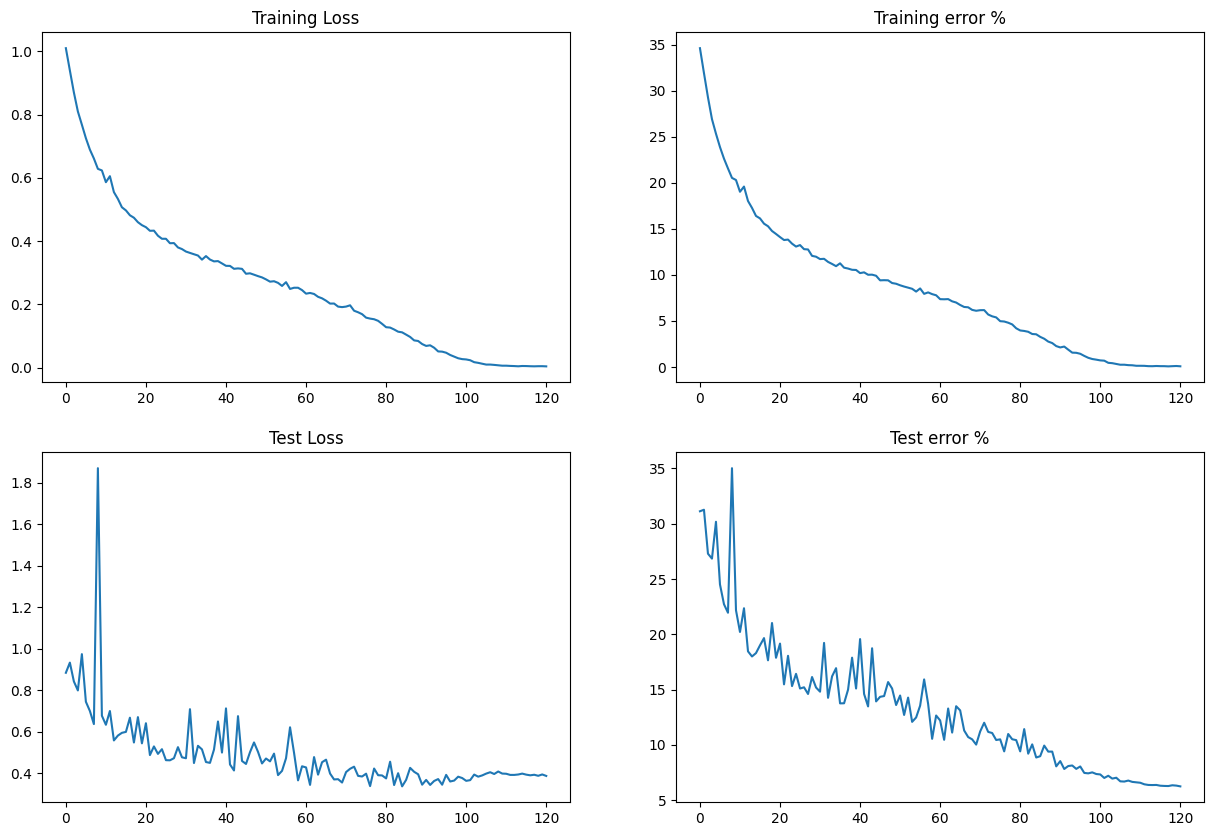

In [ ]:
# create empty lists to store the data
train_metrics = []
test_metrics = []
# open a file in read mode and load the JSON data into the appropriate lists
with open('/content/drive/MyDrive/DL HW/min_proj_2/loss_tracks/train_128_layer.json', 'r') as f:
    train_metrics = json.load(f)
with open('/content/drive/MyDrive/DL HW/min_proj_2/loss_tracks/test_128_layer.json', 'r') as f:
    test_metrics = json.load(f)


def plot_metrics(train_metrics,test_metrics):
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    axs[0, 0].plot([i[0] for i in train_metrics])
    axs[0, 0].set_title('Training Loss')
    axs[0, 1].plot([100-i[1] for i in train_metrics])
    axs[0, 1].set_title('Training error %')
    axs[1, 0].plot([i[0] for i in test_metrics])
    axs[1, 0].set_title('Test Loss')
    axs[1, 1].plot([100-i[1] for i in test_metrics])
    axs[1, 1].set_title('Test error %')

plot_metrics(train_metrics[9:],test_metrics[9:])

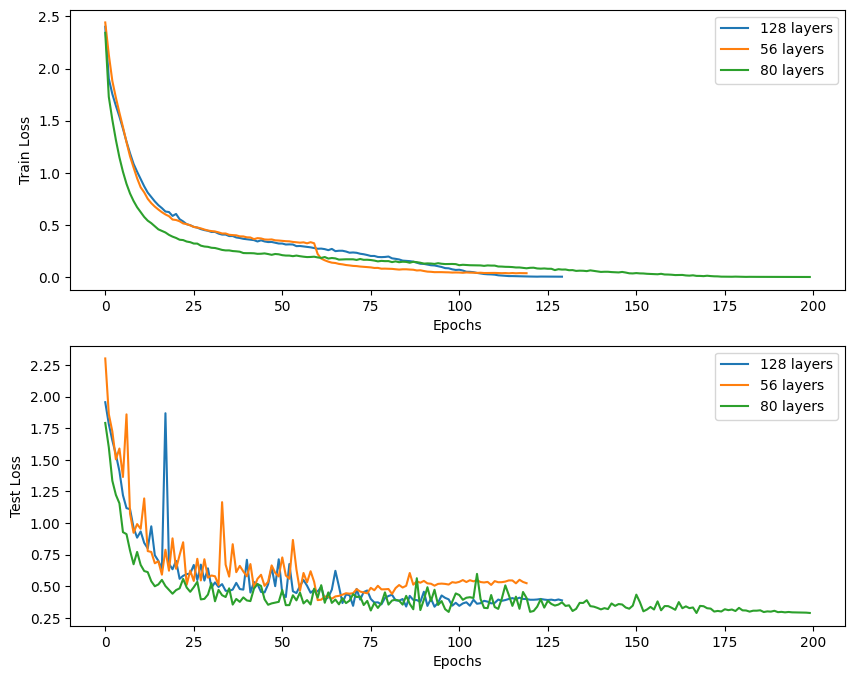

In [ ]:
import json
import matplotlib.pyplot as plt

def load_metrics(file_name):
    with open(file_name, 'r') as f:
        metrics = json.load(f)
    return metrics

# Define the file names
train_files = ['train_128_layer.json', 'train_56_layer.json', 'train_80_layer.json']
test_files = ['test_128_layer.json', 'test_56_layer.json', 'test_80_layer.json']

# Load the JSON data into lists
train_metrics = [load_metrics(file_name) for file_name in train_files]
test_metrics = [load_metrics(file_name) for file_name in test_files]

def plot_metrics(train_metrics, test_metrics):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))
    for i in range(len(train_metrics)):
        axs[0].plot([j[0] for j in train_metrics[i]], label=f'{[128, 56, 80][i]} layers')
        axs[1].plot([j[0] for j in test_metrics[i]], label=f'{[128, 56, 80][i]} layers')

    axs[0].set_ylabel('Train Loss')
    axs[0].set_xlabel('Epochs')
    axs[1].set_ylabel('Test Loss')
    axs[1].set_xlabel('Epochs')
    for ax in axs:
        ax.legend()

plot_metrics(train_metrics, test_metrics)


In [ ]:

test_loss,test_acc=evaluate(model,testloader,criterion,device)

In [ ]:
print(test_loss,test_acc)

0.29127770860361146 95.16416139240506


In [ ]:
def get_predictions(model, iterator, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()#model in eavl_mode

    labels = []
    probs = []

    with torch.no_grad():

         for batch_idx, (inputs, targets) in enumerate(iterator):

            inputs = inputs.to(device)
            targets = targets.to(device)

            y_pred = model(inputs)

            loss = criterion(y_pred, targets)

            acc = calculate_accuracy(y_pred, targets)

            epoch_loss += loss.item()
            epoch_acc += acc

            labels.append(targets)#actual_labels
            probs.append(y_pred)#predicted_labels


    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    print(epoch_loss / len(iterator), epoch_acc / len(iterator))#test_loss and test_accuracy
    return labels, probs

In [ ]:
labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)

0.2912777048311656 95.16416139240506


# Custom dataset

In [ ]:
from torch.utils.data import DataLoader, Dataset
import pickle

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

In [ ]:
# Assuming that the data is a NumPy array, we need to create a custom Dataset for it.
class CIFARTestDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data = data_dict[b'data']
        self.test_transform = test_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming that the data is a flat array per image and needs reshaping.
        # CIFAR-10 images are 32x32 with 3 channels.
        # Adjust the reshape method if the images are stored in a different format.
        image = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0)
        if self.test_transform:
            image = self.test_transform(image)
        return image

# Load the pickle file.
with open('cifar_test_nolabels.pkl', 'rb') as file:
    test_data_dict = pickle.load(file)


# Creating an instance of the Dataset for test data.
test_dataset = CIFARTestDataset(data_dict=test_data_dict, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)

In [ ]:
evaluate_model(model, testloader)

Accuracy of the model on the test images: 95.18%


In [ ]:
def predict(model, test_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions

In [ ]:
predictions = predict(model, test_loader)

In [ ]:
len(predictions)

10000

In [ ]:
np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 934,  974,  943, 1119,  944, 1052,  940, 1021, 1027, 1046]))

In [ ]:
import pandas as pd

ids = []
for i in range(10000):
  ids.append(i)


df = pd.DataFrame(
    {'ID': ids,
     'Labels': predictions
    })

df.to_csv('preds.csv', index=False)